In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.fft import fft, fftfreq

In [33]:
rate = int(102.4e6) # samples per second
T = 0.1 # 0.1 second
dt = 1/rate
Ns = int(rate*T)
time = np.arange(Ns)*dt


In [34]:
A_true=2200
f_true=150e3 # 150 kHz
phi_true = 0.3
noise = 20

def model (A,f,phi):
    return A*np.sin(2*np.pi*f*time+phi)


In [35]:
signal = model(A_true,f_true,phi_true) + noise*np.random.standard_normal(Ns)

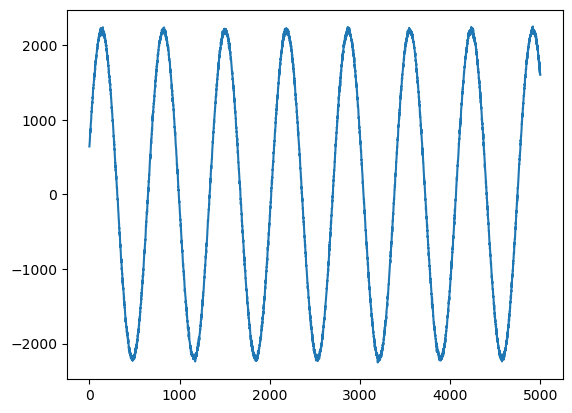

In [36]:
plt.plot(signal[0:5000])

In [37]:
def log_likelihood (A,f,phi):
    chi2 = np.sum((signal - model(A,f,phi))**2)/noise**2
    return -0.5*chi2
    
def grad_log_likelihood(params, signal, time, noise):
    A, f, phi = params
    # Compute gradients with respect to A, f, and phi
    dA = np.sum(-(signal - model(A, f, phi)) * np.sin(2 * np.pi * f * time + phi)) / noise ** 2
    df = np.sum(
        -(signal - model(A, f, phi)) * A * np.cos(2 * np.pi * f * time + phi) * 2 * np.pi * time) / noise ** 2
    dphi = np.sum(-(signal - model(A, f, phi)) * A * np.cos(2 * np.pi * f * time + phi)) / noise ** 2
    return np.array([dA, df, dphi])
    

In [38]:
# Task #1
# maximize the likelihood -- find some clever way to estimate the initial A. 
# find second derivatives around the maximum and determine errors
# show that errors are consistent with the "true" values of A,f, and phi

# Task #2:
# assume you don't know the noise level. Find a way to estimate it from the data (for example, you can find the best fitting model assuming any noise level and look at residuals)


In [39]:
# Task 1:
# Find best fit
# initial guesses for parameters
amp_guess = np.max(signal)  # ballpark guess
phase_guess = 0


In [40]:
# frequency guess
n = int(len(time))  # how many indices
dt = float(time[1] - time[0])  # time interval
frequencies = fftfreq(n, dt)  #list of frequencies
fft_values = fft(signal)  # coefficients

# find dominant frequency
idx = np.argmax(np.abs(fft_values[:n // 2]))  # consider only positive frequencies, select strongest coefficient
freq_guess = frequencies[idx]  # save the dominant frequency at index idx


In [41]:
initial_guesses = np.array([amp_guess, freq_guess, phase_guess])


In [42]:
# lambdify the likelihood for optimization
optimize_func = lambda param: -log_likelihood(param[0], param[1], param[2])


In [43]:
# find the best fitting parameters
result = minimize(optimize_func, initial_guesses, method='Nelder-Mead')
best_parameters = result.x
best_amp, best_freq, best_phase = best_parameters
best_guess = model(best_amp, best_freq, best_phase)


In [44]:
# 2nd derivatives & error
# use finite differences for Hessian approximation
eps = 1e-3 # perturbation for finite differentiation
hessian_matrix = np.zeros((3, 3)) 


In [45]:
# fill the hessian matrix
for i in range(3):
    for j in range(i, 3):
        # Compute second-order partial derivatives using finite differences
        f1 = grad_log_likelihood(best_parameters + eps * np.eye(3)[i], signal, time, noise)
        f2 = grad_log_likelihood(best_parameters + eps * np.eye(3)[j], signal, time, noise)
        f3 = grad_log_likelihood(best_parameters + eps * np.eye(3)[i] + eps * np.eye(3)[j], signal, time, noise)
        hessian_matrix[i, j] = np.sum((f3 - f1 - f2)) / (eps ** 2)
        hessian_matrix[j, i] = hessian_matrix[i, j]

parameter_uncertainties = np.sqrt(np.diag(np.linalg.inv(hessian_matrix))) #calculate each uncertainty


In [46]:
# print results
print(f"Best parameters: \n\t Amplitude: {best_amp} \n\t Frequency: {best_freq} \n\t Phase: {best_phase}")
print(
    f"Parameter uncertainties: \n\t Amplitude: {parameter_uncertainties[0]:.4e}\n\t Frequency: {parameter_uncertainties[1]:.4e}"
    f"\n\t Phase: {parameter_uncertainties[2]:.4e}")


Best parameters: 
	 Amplitude: 2199.9982232991724 
	 Frequency: 150000.00002224828 
	 Phase: 0.29999045506053557
Parameter uncertainties: 
	 Amplitude: 5.3036e-04
	 Frequency: 1.0280e-03
	 Phase: 4.7415e-04


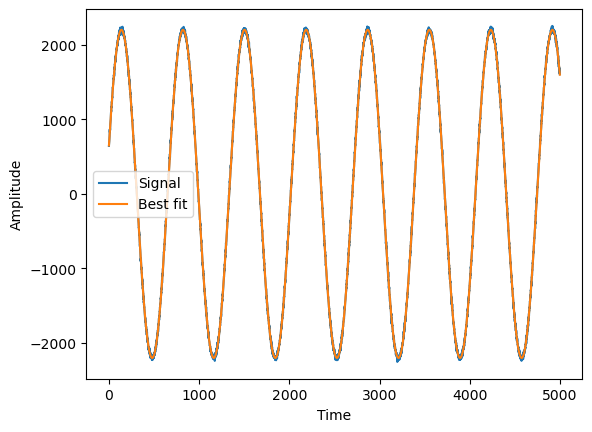

In [47]:
# plot results
plt.plot(signal[0:5000], label='Signal')
plt.plot(model(*best_parameters)[0:5000], label='Best fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [48]:
# Task 2:
# Find noise level if unknown
residuals = signal - best_guess
estimated_noise = np.std(residuals)  # average deviation from the mean
print(f"Noise estimate: {estimated_noise}")


Noise estimate: 20.00596788114714
